In [1]:
import lxml.html
import requests
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import time
import math
import re
import json
import plotly.graph_objects as go
import plotly.express as px
from bs4 import BeautifulSoup as bs4
from selenium.webdriver import Chrome
from selenium import webdriver
from selenium.webdriver.common.by import By
from datetime import datetime, timedelta

In [2]:
html = 'https://www.fangraphs.com/projections.aspx?pos=all&stats=bat&type=rzips&team=0&lg=all&players=0'
r = requests.get(html)
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)

200
text/html; charset=utf-8
utf-8


In [3]:
r.text

'\r\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\r\n<html xmlns="http://www.w3.org/1999/xhtml">\r\n<head id="Head1"><title>\r\n\t2022 Projections &raquo; ZiPS (RoS) &raquo; Batters | FanGraphs Baseball\r\n</title><meta name=\'description\' content=\'2022 ZiPS (RoS) baseball projections for batters\' />\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n<script src="//ajax.googleapis.com/ajax/libs/jquery/1.11.1/jquery.min.js" type="text/javascript"></script>\r\n\r\n<link rel="stylesheet" href="https://cdn.fangraphs.com/dist/css/head_section-style.css?v=3ab50fdfe63c149cdf5e" />\r\n\r\n<script src="https://cdn.fangraphs.com/dist/common-bundle.js?v=3ab50fdfe63c149cdf5e"></script>\r\n<script src="https://cdn.fangraphs.com/dist/head_section-bundle.js?v=3ab50fdfe63c149cdf5e"></script>\r\n\r\n\r\n\r\n<link rel="stylesheet" href="https://cdn.fangraphs.com/dist/css/desktop-style.css?v=3ab50fdfe63c149cdf5e" />\r\n<meta name="viewport" cont

In [4]:
soup = bs4(r.text, 'html.parser')

In [5]:
soup.find_all('tr', id=re.compile('ProjectionBoard1_dg1_*'))

[<tr class="rgRow" id="ProjectionBoard1_dg1_ctl00__0">
 <td class="grid_line_regular"><a href="statss.aspx?playerid=13510&amp;position=3B">José Ramírez</a></td><td class="grid_line_regular">CLE</td><td class="grid_line_regular">88</td><td align="right" class="grid_line_regular">378</td><td align="right" class="grid_line_regular">327</td><td align="right" class="grid_line_regular">92</td><td align="right" class="grid_line_regular">23</td><td align="right" class="grid_line_regular">3</td><td align="right" class="grid_line_regular">21</td><td align="right" class="grid_line_regular">61</td><td align="right" class="grid_line_regular">71</td><td align="right" class="grid_line_regular">46</td><td align="right" class="grid_line_regular">47</td><td align="right" class="grid_line_regular">3</td><td align="right" class="grid_line_regular">16</td><td align="right" class="grid_line_regular">3</td><td align="right" class="grid_line_break">.282</td><td align="right" class="grid_line_regular">.374</td

In [6]:
pd.read_html(str(soup.find_all('table', id=re.compile('ProjectionBoard1_dg1_*'))[0]))[0]

12345678910... Page size: select  553 items in 19 pages  \
                                                      Name   
0                                        José Ramírez        
1                                         Aaron Judge        
2                                           Juan Soto        
3                                        Mookie Betts        
4                                         Trea Turner        
5                                          Mike Trout        
6                                       Rafael Devers        
7                                       Manny Machado        
8                                      Yordan Alvarez        
9                                         Kyle Tucker        
10                              Vladimir Guerrero Jr.        
11                                    Xander Bogaerts        
12                                    Freddie Freeman        
13                                       Corey Seager        
14                                        Bo Bichette        
15                                   Francisco Lindor        
16                                      Marcus Semien        
17                                       Bryce Harper        
18                                        Tommy Edman        
19                                       Alex Bregman        
20                                         Matt Olson        
21                                      Nolan Arenado        
22                                       Trevor Story        
23                                      Carlos Correa        
24                                   Ronald Acuña Jr.        
25                                         Will Smith        
26                                        Pete Alonso        
27                                       Matt Chapman        
28                                   Paul Goldschmidt        
29                                       Ozzie Albies        
30  12345678910... Page size: select  553 items in...        

                                                       \
                                                 Team   
0                                                 CLE   
1                                                 NYY   
2                                                 WSN   
3                                                 LAD   
4                                                 LAD   
5                                                 LAA   
6                                                 BOS   
7                                                 SDP   
8                                                 HOU   
9                                                 HOU   
10                                                TOR   
11                                                BOS   
12                                                LAD   
13                                                TEX   
14                                                TOR   
15                                                NYM   
16                                                TEX   
17                                                PHI   
18                                                STL   
19                                                HOU   
20                                                ATL   
21                                                STL   
22                                                BOS   
23                                                MIN   
24                                                ATL   
25                                                LAD   
26                                                NYM   
27                                                TOR   
28                                                STL   
29                                                ATL   
30  12345678910... Page size: select  553 items in...   

                                                       \
                 

In [3]:
team_list = ['Lima Time!', 'Ugly Spuds', 'Harveys Wallbangers', 'Roid Ragers', 'Charmer', 'Wiscompton Wu-Tang', '10 O\'Clock Madness', 'Brewbirds', 'Trouble With The Curve', 'Lil Trump & The Ivanabees', 'Dirty Birds', 'Young Guns'] 
#'Lil Trump &amp;amp; the Ivanabees'
stat_list = ['BA', 'HR', 'R', 'RBI', 'SB', 'ERA', 'HDS', 'K', 'W', 'WHIP']

In [4]:
driver = webdriver.Chrome("C:\\WebDriver\\bin\\chromedriver.exe")
#https://chromedriver.chromium.org/downloads

In [5]:
driver.get('https://www.cbssports.com/login?master_product=150&xurl=https%3A%2F%2Fwww.cbssports.com%2Flogin')
search_box = driver.find_element_by_id('userid')
search_box.send_keys('gostros09')
search_box = driver.find_element_by_id('password')
time.sleep(1)
search_box.send_keys('Segneri9A')
time.sleep(1)
search_box.submit()
time.sleep(2)
driver.get('https://xdl.baseball.cbssports.com/teams/38')
time.sleep(2) # Let the user actually see something!
driver.find_element(By.XPATH, "//*[text()='Projections']").click()
time.sleep(3)
driver.find_elements_by_css_selector("a#projections-restofseason")[0].click()
#driver.quit()

In [6]:
def parse_name(n):
    n = n.split()
    return ' '.join(n[:n.index('|')-1])

def parse_pos(p):
    p = p.split()
    return p[p.index('|')-1]

def parse_team(t):
    t = t.split()
    return t[-1]

def str_2_int(x):
    try:
        return int(x)
    except:
        return x

In [7]:
teams_dict = {'Brewbirds':'3', 'Charmer':'36', 'Dirty Birds':'41', 'Harvey':'4', 'Lil Trump':'27', 'Lima Time':'38', 'Midnight':'30', 'Ugly Spuds':'29', 'Roiders':'44', 'Trouble':'1', 'Wu-Tang':'42', 'Young Guns':'45'}
teams_df = pd.DataFrame(teams_dict,index=['team_num']).T

In [7]:
html = driver.page_source
soup = bs4(html, 'html.parser')

In [8]:
def get_team_projections(owner):
    b = pd.read_html(str(soup.find_all('table')[1]), header=1, converters={'AB':str_2_int,'H':str_2_int, 'R':str_2_int,'HR':str_2_int,'RBI':str_2_int,'SB':str_2_int})[0].drop(columns='Edit')
    b = b[b['Pos']!='Reserves'].reset_index(drop=False).drop(columns='index')
    b.loc[b.index<14, 'Status'] = 'Start'
    b.loc[b.index>=14, 'Status'] = 'Bench'
    b['Name'] = b.Players.apply(lambda x: parse_name(x))
    b['Elig'] = b.Players.apply(lambda x: parse_pos(x))
    b['Team'] = b.Players.apply(lambda x: parse_team(x))
    b['Owner'] = owner
    
    p = pd.read_html(str(soup.find_all('table')[2]), header=1, converters={'INNs':str_2_int,'BBI':str_2_int, 'HA':str_2_int, 'W':str_2_int,'S':str_2_int,'K':str_2_int})[0].drop(columns='Edit')
    p = p[~p['Pos'].str.contains('Reserve')].reset_index(drop=False).drop(columns='index')
    p['ER'] = (p['ERA'].astype(float)/9)*p['INNs'].astype(float)
    p.loc[p.index<9, 'Status'] = 'Start'
    p.loc[p.index>=9, 'Status'] = 'Bench'
    p['Name'] = p.Players.apply(lambda x: parse_name(x))
    p['Elig'] = p.Players.apply(lambda x: parse_pos(x))
    p['Team'] = p.Players.apply(lambda x: parse_team(x))
    p['Owner'] = owner
    return b, p

In [9]:
driver.get('https://xdl.baseball.cbssports.com/teams/'+num)
driver.find_element(By.XPATH, "//*[text()='Projections']").click()
time.sleep(3)
html = driver.page_source
soup = bs4(html, 'html.parser')

NameError: name 'num' is not defined

In [10]:
b = pd.DataFrame()
p = pd.DataFrame()
for owner, num in teams_dict.items():
    driver.get('https://xdl.baseball.cbssports.com/teams/'+num)
    driver.find_element(By.XPATH, "//*[text()='Projections']").click()
    time.sleep(2)
    driver.find_elements_by_css_selector("a#projections-restofseason")[0].click()
    time.sleep(4)
    html = driver.page_source
    soup = bs4(html, 'html.parser')
    result = get_team_projections(owner)
    b = b.append(result[0])
    p = p.append(result[1])

ValueError: '|' is not in list

In [16]:
b.to_csv('ros-proj-h.csv')
p.to_csv('ros-proj-p.csv')

In [ ]:
driver.quit()

In [7]:
#b = pd.read_csv('data\\2022-zips-ros-proj-h.csv')
b = pd.read_csv('ros-proj-h.csv')
p = pd.read_csv('ros-proj-p.csv')
#p = pd.read_csv('data\\2022-zips-ros-proj-p.csv')

In [11]:
b[b['Name'].isin(['Juan Soto'])]

,Pos,Players,AB,R,H,1B,2B,3B,HR,RBI,BB,KO,SB,CS,BA,OBP,SLG,Roto Rank,Status,Name,Elig,Team,Owner
10,OF,Juan Soto OF | SD,175,40,50,26,10,1,13,32,56,34,4,2,.286,.459,.577,6,Start,Juan Soto,OF,SD,Lima Time


In [12]:
p[p['Name'].isin(['Dylan Cease', 'Marcus Stroman', 'Lance McCullers'])]

,Pos,Players,INNs,GS,QS,CG,W,L,S,BS,K,BBI,HA,ERA,WHIP,Roto Rank,ER,Status,Name,Elig,Team,Owner
3,SP,Marcus Stroman SP | CHC,57,10,5,0,3,3,0,0,47,15,53,3.79,1.19,299,24.003333,Start,Marcus Stroman,SP,CHC,Lima Time
11,SP,Lance McCullers SP | HOU,49,9,5,0,4,1,0,0,48,17,41,3.31,1.18,187,18.021111,Bench,Lance McCullers,SP,HOU,Lima Time
0,SP,Dylan Cease SP | CHW,54,10,4,0,4,3,0,0,60,20,41,2.67,1.13,88,16.020000,Start,Dylan Cease,SP,CHW,Roiders


In [34]:
p.sort_values('zK', ascending=False).head(15)

,Unnamed: 0,Pos,Players,INNs,GS,QS,CG,W,L,S,BS,K,BBI,HA,ERA,WHIP,Roto Rank,ER,Status,Name,Elig,Team,Owner,zW,zK,zS,zER,zERA,zH+BB,zWHIP,z,$
60,2,SP,Gerrit Cole SP | NYY,114,19,13,1,9,4,0,0,133,30,91,3.08,1.06,32,39.013333,Start,Gerrit Cole,SP,NYY,Lil Trump,1.445982,2.432502,-0.526974,23.151737,0.810677,9.322420,1.374003,5.536190,14.965697
127,1,SP,Corbin Burnes SP | MIL,101,17,13,0,7,4,0,0,120,27,82,2.76,1.08,59,30.973333,Start,Corbin Burnes,SP,MIL,Trouble,0.736136,1.882191,-0.526974,52.831626,1.530919,6.461091,1.007121,4.629393,12.514400
3,3,SP,Aaron Nola SP | PHI,115,18,10,0,7,4,0,0,118,24,93,3.21,1.02,57,41.016667,Start,Aaron Nola,SP,PHI,Brewbirds,0.736136,1.797528,-0.526974,8.404822,0.452813,14.465599,2.033466,4.492969,12.145612
88,1,SP,Lucas Giolito SP | CHW,107,18,9,0,8,4,0,0,112,33,84,3.20,1.09,66,38.044444,Start,Lucas Giolito,SP,CHW,Midnight,1.091059,1.543538,-0.526974,8.890139,0.464590,5.320166,0.860830,3.433043,9.280368
131,5,SP,Zack Wheeler SP | PHI,112,17,13,1,9,4,0,0,109,25,97,3.05,1.09,52,37.955556,Start,Zack Wheeler,SP,PHI,Trouble,1.445982,1.416543,-0.526974,26.105566,0.882357,6.036062,0.952623,4.170530,11.273981
0,0,SP,Shane Bieber SP | CLE,105,17,13,0,5,5,0,0,109,29,102,3.94,1.25,294,45.966667,Start,Shane Bieber,SP,CLE,Brewbirds,0.026291,1.416543,-0.526974,-68.976032,-1.424990,-10.966192,-1.227423,-1.736554,-4.694338
74,1,SP,Dylan Cease SP | CHW,96,18,5,0,7,5,0,0,106,37,76,3.09,1.18,119,32.960000,Start,Dylan Cease,SP,CHW,Lima Time,0.736136,1.289548,-0.526974,18.536199,0.698671,-3.254804,-0.238661,1.958720,5.294907
128,2,SP,Yu Darvish SP | SD,111,18,13,0,8,6,0,0,105,27,96,3.49,1.11,95,43.043333,Start,Yu Darvish,SP,SD,Trouble,1.091059,1.247216,-0.526974,-22.967520,-0.308501,3.892883,0.677822,2.180623,5.894765
30,2,SP,Kevin Gausman SP | TOR,101,17,11,0,7,6,0,0,105,24,92,3.21,1.15,115,36.023333,Start,Kevin Gausman,SP,TOR,Dirty Birds,0.736136,1.247216,-0.526974,7.381626,0.427983,-0.538909,0.109574,1.993935,5.390101
5,5,SP,"Logan Webb RP,SP | SF",108,18,11,0,7,4,0,0,104,32,94,3.00,1.17,106,36.000000,Start,Logan Webb,"RP,SP",SF,Brewbirds,0.736136,1.204884,-0.526974,30.573224,0.990774,-2.536655,-0.146579,2.258241,6.104588


In [10]:
#df = b[b['Status']=='Start'].groupby('Owner').agg({'R':'sum', 'RBI':'sum', 'HR':'sum', 'SB':'sum', 'H':'sum', 'AB':'sum'})
def get_proj_batting_stats_by_owner(b):
    df = b[b['Status']=='Start'].groupby("Owner").apply(lambda s: pd.Series({ 
        "HR": s["HR"].sum(), 
        "R": s["R"].sum(),
        'RBI': s['RBI'].sum(),
        'SB': s['SB'].sum(),
        "BA": s["H"].sum()/s["AB"].sum(),
        'H': s['H'].sum(),
        'AB': s['AB'].sum()
    }))
    return df

def get_batting_ranks(proj):
    b_ranks = proj.drop(columns=['H', 'AB']).rank()
    b_ranks['Pts'] = b_ranks.sum(axis=1)
    return b_ranks

proj_batting_stats_by_owner = get_proj_batting_stats_by_owner(b)
b_ranks = get_batting_ranks(proj_batting_stats_by_owner)

In [11]:
b_ranks.sort_values('Pts', ascending=False)

,HR,R,RBI,SB,BA,Pts
Owner,,,,,,
Roiders,12.0,12.0,12.0,7.0,10.0,53.0
Charmer,10.0,10.0,11.0,12.0,7.0,50.0
Harvey,11.0,11.0,10.0,5.0,2.0,39.0
Trouble,5.0,5.5,8.0,6.0,11.0,35.5
Wu-Tang,6.0,9.0,5.0,11.0,4.0,35.0
Brewbirds,7.0,5.5,6.0,10.0,6.0,34.5
Dirty Birds,4.0,8.0,7.0,1.0,12.0,32.0
Young Guns,9.0,7.0,9.0,2.0,5.0,32.0
Ugly Spuds,2.0,3.0,2.0,9.0,9.0,25.0


In [12]:
#dfp = p[p['Status']=='Start'].groupby('Owner').agg({'W':'sum', 'K':'sum', 'S':'sum', 'INNs':'sum', 'ER':'sum', 'HA':'sum', 'BBI':'sum'})
dfp = p[p['Status']=='Start'].groupby("Owner").apply(lambda s: pd.Series({ 
    "W": s["W"].sum(), 
    "K": s["K"].sum(),
    'S': s['S'].sum(),
    'ERA': s['ER'].sum()/s['INNs'].sum()*9,
    "WHIP": (s["HA"].sum()+s['BBI'].sum())/s["INNs"].sum(),
}))

p_ranks = dfp.rank()
p_ranks['Pts'] = p_ranks.sum(axis=1)
p_ranks.sort_values('Pts', ascending=False)

,W,K,S,ERA,WHIP,Pts
Owner,,,,,,
Trouble,12.0,12.0,5.0,9.0,7.0,45.0
Lima Time,7.0,8.0,10.0,11.0,8.0,44.0
Roiders,8.0,6.0,2.5,12.0,11.0,39.5
Brewbirds,2.0,7.0,11.5,8.0,9.0,37.5
Young Guns,5.5,3.0,7.0,10.0,12.0,37.5
Midnight,10.5,11.0,9.0,3.0,2.0,35.5
Wu-Tang,9.0,10.0,4.0,4.0,5.0,32.0
Dirty Birds,10.5,4.5,1.0,5.0,10.0,31.0
Lil Trump,4.0,9.0,6.0,6.0,3.0,28.0


In [13]:
dfp.sort_values('W', ascending=False)

,W,K,S,ERA,WHIP
Owner,,,,,
Trouble,53.0,778.0,30.0,3.331696,1.144638
Dirty Birds,50.0,660.0,6.0,3.262328,1.173280
Midnight,50.0,751.0,46.0,3.145997,1.105606
Wu-Tang,47.0,710.0,24.0,3.188571,1.120448
Roiders,46.0,665.0,19.0,3.525347,1.187755
Lima Time,44.0,678.0,47.0,3.437652,1.160475
Charmer,43.0,606.0,39.0,3.276246,1.116393
Young Guns,43.0,658.0,38.0,3.425007,1.195509
Lil Trump,42.0,679.0,37.0,3.265434,1.116246


<AxesSubplot:xlabel='Owner'>

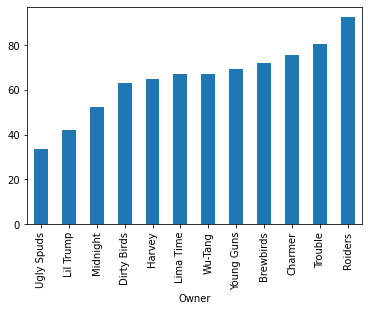

In [14]:
(b_ranks['Pts']+p_ranks['Pts']).sort_values().plot(kind='bar')

In [15]:
z_table = b[b['Status']=='Start'].agg({'HR':['mean','std'], 'R':['mean', 'std'], 'RBI':['mean','std'], 'SB':['mean','std'], 'H':['mean','std'], 'AB':['mean','std']})
z_table = z_table.join(p[p['Status']=='Start'].agg({'W':['mean','std'], 'K':['mean', 'std'], 'S':['mean','std'], 'ER':['mean','std'], 'HA':['mean','std'], 'BBI':['mean','std'], 'INNs':['mean', 'std']}))
z_table

,HR,R,RBI,SB,H,AB,W,K,S,ER,HA,BBI,INNs
mean,12.119048,43.541667,42.630952,4.761905,78.416667,296.577381,4.925926,75.537037,3.879630,28.473673,65.611111,23.620370,78.055556
std,5.493392,11.120383,12.408979,4.963626,16.423445,50.561932,2.817514,23.622983,7.362087,12.485728,28.041302,8.321482,28.575473


In [16]:
for stat in ['R', 'HR', 'RBI', 'SB']:
    b['z'+stat] = (b[stat]-z_table[stat]['mean']) / z_table[stat]['std']

b['zBA'] = b['H']-(b['AB']*(z_table['H']['mean']) / z_table['AB']['mean'])
b['zBA'] = (b['zBA']-b['zBA'].mean())/b['zBA'].std()
b['z'] = b['zBA'] + b['zHR'] + b['zR'] + b['zRBI'] + b['zSB']

for stat in ['W', 'K', 'S']:
    p['z'+stat] = (p[stat]-z_table[stat]['mean']) / z_table[stat]['std']

p['zER'] = ((p['ER']*9) - ((p['INNs'] * z_table['ER']['mean'] * 9) / z_table['INNs']['mean'])) * -1
p['zERA'] = (p['zER'] - p['zER'].mean()) / p['zER'].std()
p['zH+BB'] = ((p['HA']+p['BBI']) - (p['INNs'] * ((z_table['HA']['mean'] + z_table['BBI']['mean']) / z_table['INNs']['mean']))) * -1
p['zWHIP'] = (p['zH+BB'] - p['zH+BB'].mean()) / p['zH+BB'].std()
p['z'] = p['zERA'] + p['zWHIP'] + p['zW'] + p['zS'] + p['zK']

In [17]:
p['zER'].mean(), p['zER'].std()
p.sort_values('z').tail(15)

,Unnamed: 0,Pos,Players,INNs,GS,QS,CG,W,L,S,BS,K,BBI,HA,ERA,WHIP,Roto Rank,ER,Status,Name,Elig,Team,Owner,zW,zK,zS,zER,zERA,zH+BB,zWHIP,z
88,1,SP,Lucas Giolito SP | CHW,107,18,9,0,8,4,0,0,112,33,84,3.20,1.09,66,38.044444,Start,Lucas Giolito,SP,CHW,Midnight,1.091059,1.543538,-0.526974,8.890139,0.464590,5.320166,0.860830,3.433043
100,0,SP,Sandy Alcantara SP | MIA,117,17,14,1,7,5,0,0,99,31,93,3.08,1.06,80,40.040000,Start,Sandy Alcantara,SP,MIA,Ugly Spuds,0.736136,0.993226,-0.526974,23.760993,0.825462,9.751957,1.429079,3.456928
141,2,SP,Alek Manoah SP | TOR,109,17,14,0,9,3,0,0,99,29,89,3.06,1.08,61,37.060000,Start,Alek Manoah,SP,TOR,Wu-Tang,1.445982,0.993226,-0.526974,24.316310,0.838937,6.606524,1.025768,3.776939
42,0,SP,"Tony Gonsolin RP,SP | LAD",82,17,8,0,9,1,0,0,81,28,58,2.63,1.05,75,23.962222,Start,Tony Gonsolin,"RP,SP",LAD,Harvey,1.445982,0.231256,-0.526974,53.553004,1.548425,7.740688,1.171192,3.869881
92,5,SP,Julio Urias SP | LAD,101,17,8,0,9,4,0,0,96,25,82,3.03,1.06,63,34.003333,Start,Julio Urias,SP,LAD,Midnight,1.445982,0.866231,-0.526974,25.561626,0.869158,8.461091,1.263563,3.917959
93,6,RP,"Nestor Cortes RP,SP | NYY",102,17,7,0,6,5,0,0,96,26,81,2.65,1.05,86,30.033333,Start,Nestor Cortes,"RP,SP",NYY,Midnight,0.381213,0.866231,-0.526974,64.574712,1.815889,9.604270,1.410142,3.946502
116,3,SP,Carlos Rodon SP | SF,93,16,8,0,9,4,0,0,95,28,73,2.71,1.09,62,28.003333,Start,Carlos Rodon,SP,SF,Roiders,1.445982,0.823899,-0.526974,53.296943,1.542211,5.315658,0.860252,4.145370
131,5,SP,Zack Wheeler SP | PHI,112,17,13,1,9,4,0,0,109,25,97,3.05,1.09,52,37.955556,Start,Zack Wheeler,SP,PHI,Trouble,1.445982,1.416543,-0.526974,26.105566,0.882357,6.036062,0.952623,4.170530
47,5,RP,David Bednar RP | PIT,66,0,0,0,1,1,13,3,99,20,47,2.05,1.02,82,15.033333,Start,David Bednar,RP,PIT,Harvey,-1.393401,0.993226,1.238829,81.383637,2.223792,8.449822,1.262118,4.324564
3,3,SP,Aaron Nola SP | PHI,115,18,10,0,7,4,0,0,118,24,93,3.21,1.02,57,41.016667,Start,Aaron Nola,SP,PHI,Brewbirds,0.736136,1.797528,-0.526974,8.404822,0.452813,14.465599,2.033466,4.492969


In [18]:
conv = (260*12)/(b[b['z']>0].z.sum() + p[p['z']>0].z.sum())
conv

7.723567617572538

In [19]:
b['$'] = b['z'] * conv *.65
p['$'] = p['z'] * conv *.35

In [20]:
b[b['Status']=='Start'].groupby('Owner')['$'].sum()

Owner
Brewbirds       26.122397
Charmer        112.583845
Dirty Birds     -1.537588
Harvey          38.879043
Lil Trump     -135.437216
Lima Time      -58.597061
Midnight       -73.471638
Roiders        134.548059
Trouble         24.521999
Ugly Spuds     -36.769906
Wu-Tang         25.646844
Young Guns       4.564143
Name: $, dtype: float64

In [21]:
#ba_pts = row['H']-(row['AB']*(qual_avgs['H'][0]/qual_avgs['AB'][0]))
#zBA = (ba_pts-qual_avgs['zlgBA'][0])/qual_avgs['zlgBA'][1]
play = b[(b['Owner']=='Lima Time') & (b['Status']=='Start')]
bench = b[(b['Owner']=='Lima Time') & (b['Status']=='Bench')]

In [22]:
play

,Unnamed: 0,Pos,Players,AB,R,H,1B,2B,3B,HR,RBI,BB,KO,SB,CS,BA,OBP,SLG,Roto Rank,Status,Name,Elig,Team,Owner,zR,zHR,zRBI,zSB,zBA,z,$
92,0,C,Adley Rutschman C | BAL,270,31,60,37,13,1,9,30,22,75,1,0,0.222,0.291,0.378,417,Start,Adley Rutschman,C,BAL,Lima Time,-1.127809,-0.567782,-1.017888,-0.757894,-1.505300,-4.976674,-24.984489
93,1,1B,"Juan Yepez 1B,OF | STL",183,25,47,30,9,0,8,26,17,43,1,0,0.257,0.324,0.437,404,Start,Juan Yepez,"1B,OF",STL,Lima Time,-1.667359,-0.749819,-1.340235,-0.757894,-0.119630,-4.634937,-23.268861
94,2,2B,"Ian Happ 2B,OF | CHC",263,38,68,42,15,1,10,37,36,68,6,2,0.259,0.352,0.437,169,Start,Ian Happ,"2B,OF",CHC,Lima Time,-0.498334,-0.385745,-0.453780,0.249434,-0.140745,-1.229171,-6.170830
95,3,3B,Alex Bregman 3B | HOU,322,48,77,49,18,0,10,46,45,53,0,0,0.239,0.338,0.388,192,Start,Alex Bregman,3B,HOU,Lima Time,0.400915,-0.385745,0.271501,-0.959360,-1.054978,-1.727666,-8.673435
96,4,SS,"Bobby Witt 3B,SS | KC",357,51,91,54,21,3,13,50,20,88,13,3,0.255,0.300,0.440,42,Start,Bobby Witt,"3B,SS",KC,Lima Time,0.670690,0.160366,0.593848,1.659693,-0.397580,2.687018,13.489685
97,5,MI,Brandon Crawford SS | SF,325,45,85,51,18,4,12,51,30,73,4,2,0.262,0.334,0.452,91,Start,Brandon Crawford,SS,SF,Lima Time,0.131141,-0.021671,0.674435,-0.153498,-0.056681,0.573725,2.880285
98,6,CI,"Brandon Drury 2B,3B,OF | CIN",191,33,50,29,11,1,9,28,19,49,2,1,0.262,0.336,0.471,309,Start,Brandon Drury,"2B,3B,OF",CIN,Lima Time,-0.947959,-0.567782,-1.179062,-0.556429,0.002928,-3.248303,-16.307517
99,7,OF,Randy Arozarena OF | TB,326,49,87,54,19,2,12,43,25,92,15,6,0.267,0.336,0.448,43,Start,Randy Arozarena,OF,TB,Lima Time,0.490840,-0.021671,0.029740,2.062624,0.183736,2.745270,13.782132
100,8,OF,Charlie Blackmon OF | COL,344,49,92,60,18,2,12,52,30,65,3,1,0.267,0.333,0.436,78,Start,Charlie Blackmon,OF,COL,Lima Time,0.490840,-0.021671,0.755022,-0.354963,0.217079,1.086307,5.453605
101,9,OF,Byron Buxton OF | MIN,320,62,80,35,18,0,27,53,32,89,6,1,0.250,0.332,0.559,17,Start,Byron Buxton,OF,MIN,Lima Time,1.659865,2.708882,0.835608,0.249434,-0.566161,4.887629,24.537454


In [23]:
bench

,Unnamed: 0,Pos,Players,AB,R,H,1B,2B,3B,HR,RBI,BB,KO,SB,CS,BA,OBP,SLG,Roto Rank,Status,Name,Elig,Team,Owner,zR,zHR,zRBI,zSB,zBA,z,$
106,14,1B,Yuli Gurriel 1B | HOU,327,41,86,56,22,0,8,38,26,46,3,0,0.263,0.320,0.404,209,Bench,Yuli Gurriel,1B,HOU,Lima Time,-0.228559,-0.749819,-0.373194,-0.354963,0.008589,-1.697946,-8.524231
107,15,SS,"Fernando Tatis OF,SS | SD",217,46,64,32,15,1,16,44,26,64,11,2,0.295,0.372,0.595,34,Bench,Fernando Tatis,"OF,SS",SD,Lima Time,0.221066,0.706476,0.110327,1.256762,0.989959,3.284590,16.489690
108,16,OF,Tyler O'Neill OF | STL,312,51,84,52,15,2,15,55,26,98,10,4,0.269,0.330,0.474,31,Bench,Tyler O'Neill,OF,STL,Lima Time,0.670690,0.524440,0.996782,1.055296,0.280934,3.528142,17.712397
109,17,DH,Jesus Sanchez OF | MIA,295,40,71,40,14,3,14,40,23,86,2,1,0.241,0.302,0.451,178,Bench,Jesus Sanchez,OF,MIA,Lima Time,-0.318484,0.342403,-0.212020,-0.556429,-0.897209,-1.641739,-8.242054
110,18,DH,Spencer Torkelson 1B | DET,324,37,76,46,15,1,14,42,38,91,1,0,0.235,0.321,0.417,226,Bench,Spencer Torkelson,1B,DET,Lima Time,-0.588259,0.342403,-0.050846,-0.757894,-1.266751,-2.321348,-11.653909


In [24]:
def get_position_list(player):
    elig = player.split(',')
    for pos in elig:
        if pos in ['1B', '3B']:
            elig.extend(['CI'])
        elif pos in ['2B', 'SS']:
            elig.extend(['MI'])
    elig.extend(['DH'])
    return list(dict.fromkeys(elig))

def check_if_better(cur, new):
    if new > cur:
        return new
    else:
        return cur

In [25]:
# Line-up Optimization Algorithm
base_z = play['z'].sum()

for bench_spot in range(bench.shape[0]):
    optimal_z = play['z'].sum()

    for i in get_position_list(bench['Elig'].iloc[bench_spot]):
        mask = (play['Pos']==i)
        if i in ['C', '1B', '2B', 'SS', '3B', 'MI', 'CI']:
            optimal_z = check_if_better(base_z + bench.iloc[bench_spot]['z'] - play[mask]['z'].iloc[0], optimal_z)
        if i=='OF':
            optimal_z = check_if_better(base_z + bench.iloc[bench_spot]['z'] - play[mask]['z'].iloc[0], optimal_z)
            optimal_z = check_if_better(base_z + bench.iloc[bench_spot]['z'] - play[mask]['z'].iloc[1], optimal_z)
            optimal_z = check_if_better(base_z + bench.iloc[bench_spot]['z'] - play[mask]['z'].iloc[2], optimal_z)
            optimal_z = check_if_better(base_z + bench.iloc[bench_spot]['z'] - play[mask]['z'].iloc[3], optimal_z)
            optimal_z = check_if_better(base_z + bench.iloc[bench_spot]['z'] - play[mask]['z'].iloc[4], optimal_z)
        if i=='DH':
            optimal_z = check_if_better(base_z + bench.iloc[bench_spot]['z'] - play[mask]['z'].iloc[0], optimal_z)
            optimal_z = check_if_better(base_z + bench.iloc[bench_spot]['z'] - play[mask]['z'].iloc[1], optimal_z)
    
    if optimal_z > play['z'].sum():
        print('The line-up is not optimal.',bench.iloc[bench_spot]['Name'],'should go in.')
    else:
        print('The line-up is already optimal.',bench.iloc[bench_spot]['Name'],'should stay on the bench.')

The line-up is not optimal. Yuli Gurriel should go in.
The line-up is not optimal. Fernando Tatis should go in.
The line-up is not optimal. Tyler O'Neill should go in.
The line-up is not optimal. Jesus Sanchez should go in.
The line-up is not optimal. Spencer Torkelson should go in.


In [26]:
b[b['Elig'].str.contains('OF')].groupby('Owner')['z'].mean()

Owner
Brewbirds      0.007579
Charmer       -1.299954
Dirty Birds   -0.452869
Harvey         0.002285
Lil Trump     -0.683501
Lima Time     -0.235184
Midnight      -2.121538
Roiders        1.683571
Trouble       -1.842835
Ugly Spuds    -1.783627
Wu-Tang       -0.191010
Young Guns     0.503125
Name: z, dtype: float64

In [27]:
b[b['Owner']=='Brewbirds']

,Unnamed: 0,Pos,Players,AB,R,H,1B,2B,3B,HR,RBI,BB,KO,SB,CS,BA,OBP,SLG,Roto Rank,Status,Name,Elig,Team,Owner,zR,zHR,zRBI,zSB,zBA,z,$
0,0,C,Alejandro Kirk C | TOR,188,28,53,36,10,0,7,24,22,31,0,0,0.282,0.358,0.447,381,Start,Alejandro Kirk,C,TOR,Brewbirds,-1.397584,-0.931855,-1.501409,-0.959360,0.528371,-4.261837,-21.395782
1,1,1B,"Jared Walsh 1B,OF | LAA",316,41,85,51,16,2,16,55,23,92,1,1,0.269,0.325,0.484,74,Start,Jared Walsh,"1B,OF",LAA,Brewbirds,-0.228559,0.706476,0.996782,-0.757894,0.272952,0.989757,4.968894
2,2,2B,"Whit Merrifield 2B,OF | KC",366,50,92,65,20,1,6,42,24,56,16,2,0.251,0.296,0.361,81,Start,Whit Merrifield,"2B,OF",KC,Brewbirds,0.580765,-1.113892,-0.050846,2.264090,-0.588691,1.091426,5.479304
3,3,3B,"Jon Berti 2B,3B,OF,SS | MIA",115,18,32,21,6,2,3,12,13,30,9,1,0.278,0.354,0.444,475,Start,Jon Berti,"2B,3B,OF,SS",MIA,Brewbirds,-2.296833,-1.660003,-2.468451,0.853831,0.293105,-5.278351,-26.499007
4,4,SS,Carlos Correa SS | MIN,327,45,84,53,17,0,14,45,33,91,0,0,0.257,0.329,0.437,131,Start,Carlos Correa,SS,MIN,Brewbirds,0.131141,0.342403,0.190914,-0.959360,-0.268455,-0.563358,-2.828235
5,5,MI,"Gleyber Torres 2B,SS | NYY",327,46,89,54,19,3,13,47,28,69,5,4,0.272,0.333,0.468,71,Start,Gleyber Torres,"2B,SS",NYY,Brewbirds,0.221066,0.160366,0.352088,0.047968,0.424154,1.205641,6.052701
6,6,CI,Jose Abreu 1B | CHW,329,48,91,53,21,1,16,58,37,68,0,0,0.277,0.361,0.492,53,Start,Jose Abreu,1B,CHW,Brewbirds,0.400915,0.706476,1.238543,-0.959360,0.627946,2.014520,10.113532
7,7,OF,Harrison Bader OF | STL,258,36,69,47,11,3,8,29,16,54,13,3,0.267,0.319,0.426,150,Start,Harrison Bader,OF,STL,Brewbirds,-0.678184,-0.749819,-1.098475,1.659693,0.180906,-0.685879,-3.443329
8,8,OF,Starling Marte OF | NYM,339,63,101,68,19,4,10,48,23,69,19,5,0.298,0.355,0.466,12,Start,Starling Marte,OF,NYM,Brewbirds,1.749790,-0.385745,0.432674,2.868487,1.646904,6.312110,31.688806
9,9,OF,"Ryan Mountcastle 1B,OF | BAL",330,46,87,51,16,0,20,57,22,93,2,1,0.264,0.312,0.494,45,Start,Ryan Mountcastle,"1B,OF",BAL,Brewbirds,0.221066,1.434624,1.157956,-0.556429,0.037233,2.294449,11.518866


In [28]:
trade = b.copy()

In [29]:
trade.loc[trade['Name']=='Nolan Arenado', 'Owner'] = 'Lima Time'
trade.loc[trade['Name']=='Tyler O\'Neill', 'Owner'] = 'Dirty Birds'

In [30]:
trade[trade['Name'].isin(['Ryan McMahon', 'Tyler O\'Neill'])]

,Unnamed: 0,Pos,Players,AB,R,H,1B,2B,3B,HR,RBI,BB,KO,SB,CS,BA,OBP,SLG,Roto Rank,Status,Name,Elig,Team,Owner,zR,zHR,zRBI,zSB,zBA,z,$
108,16,OF,Tyler O'Neill OF | STL,312,51,84,52,15,2,15,55,26,98,10,4,0.269,0.330,0.474,31,Bench,Tyler O'Neill,OF,STL,Dirty Birds,0.670690,0.524440,0.996782,1.055296,0.280934,3.528142,17.712397
216,5,MI,"Ryan McMahon 2B,3B | COL",339,46,84,51,20,2,11,52,40,102,2,1,0.248,0.332,0.416,130,Start,Ryan McMahon,"2B,3B",COL,Young Guns,0.221066,-0.203708,0.755022,-0.556429,-0.707966,-0.492015,-2.470073


In [ ]:
get_proj_batting_stats_by_owner(trade)

In [ ]:
proj_batting_stats_by_owner

In [ ]:
get_batting_ranks(get_proj_batting_stats_by_owner(trade)).sort_values('Pts', ascending=False)

In [2]:
from pybaseball.analysis.projections.marcels import MarcelProjectionsPitching
from pybaseball.analysis.projections.marcels import MarcelProjectionsBatting
from pybaseball.lahman import people

In [3]:
ppl = people()  # for merging player names onto the projections
ppl['Player'] = ppl['nameFirst'].str.cat(ppl['nameLast'], ' ')
marcel_batting = MarcelProjectionsBatting()
marcel_pitching = MarcelProjectionsPitching()

In [4]:
pitchers = marcel_pitching.projections(2022)
batters = marcel_batting.projections(2022)
pitchers = pd.merge(ppl[['playerID', 'Player']], pitchers, on='playerID', how='right')
batters = pd.merge(ppl[['playerID', 'Player']], batters, on='playerID', how='right')

In [5]:
pitchers.sort_values('SO', ascending=False).head()

,playerID,Player,H,HR,ER,BB,SO,HBP,R
151,colege01,Gerrit Cole,130.177267,23.192154,59.373183,42.552569,202.517472,3.643598,64.763624
623,rayro02,Robbie Ray,138.906002,28.410704,69.298920,63.674739,197.972865,4.755971,73.120325
110,burneco01,Corbin Burnes,121.304234,12.883614,54.609713,43.894744,195.411654,6.053582,58.465337
684,scherma01,Max Scherzer,129.197259,21.331163,56.873181,42.434221,192.318967,7.702814,61.405805
546,nolaaa01,Aaron Nola,140.981379,22.381489,75.761725,47.904610,185.471218,7.691862,80.211307


In [6]:
batters.sort_values('HR', ascending=False).head(20)

,playerID,Player,1B,2B,3B,HR,BB,HBP,SB,CS,SO,SH,SF
457,perezsa02,Salvador Perez,79.766021,23.153460,0.462172,34.637249,27.588166,9.246612,2.549379,0.527804,136.162346,0.233162,3.343123
19,alonspe01,Pete Alonso,64.486815,22.145400,1.847228,33.491687,53.438600,11.878372,2.742784,0.374421,123.623150,0.161206,2.990708
577,tatisfe02,Fernando Tatis,67.706886,24.646915,2.545753,33.192593,52.889644,5.044703,19.861542,4.424568,127.836220,0.186770,3.458426
435,olsonma02,Matt Olson,66.517193,25.197639,0.664957,31.850932,66.383967,7.804460,3.087218,0.790537,121.092856,0.172391,5.161963
165,duvalad01,Adam Duvall,56.534760,17.076189,1.618264,31.047919,34.636132,4.950462,3.807755,0.487355,143.681977,0.207985,2.799483
299,judgeaa01,Aaron Judge,73.962155,20.377802,0.640943,30.593361,61.679696,3.944355,4.644201,1.745233,138.795480,0.187909,3.051391
235,guerrvl02,Vladimir Guerrero,90.418647,26.939825,1.905609,30.257269,62.928658,4.801660,3.240459,1.015266,95.877137,0.181053,1.948848
341,lowebr01,Brandon Lowe,61.822590,25.449261,1.575918,30.112430,54.486206,7.836752,6.718971,0.868284,143.833162,0.190505,2.916633
200,gallojo01,Joey Gallo,46.841707,16.954584,1.075457,29.815991,82.511783,5.797018,5.718319,0.973576,174.443991,0.442274,1.364298
128,cruzne02,Nelson Cruz,70.293503,19.579382,0.714353,29.723447,48.092467,6.518953,2.285479,0.666265,124.625799,0.165736,4.661932
